<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/MINE_0218.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 새로운 가정
+ feature의 importance 는 p(y|x)의 관계이지, p(x)와는 독립적이다.
+ 맞다. 그러나, DNA철학(?) 즉, 미래(성장?)의 내용이 DNA에 들어 있듯이, 특정 기간의 p(y|x) 내부에는 이후의 p(y|x) 변화를 감지할 수 있는 정보가 들어있지 않을까?
+ 즉, 일정기간(범위)의 학습과정에서 내포된 importance의 변화를 반영한 학습을 할 수 있지 않겠는가?

In [1]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,InputLayer,Dense, Dropout
import random
np.random.seed(1337)

In [4]:
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [5]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]   
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)
    
    #if ks_stat == minS:
    #    ks_stat = -ks_stat
    
    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [6]:


from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
     
COLUMNS = ['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9']     

## concept drift의 case #2

Concept(Rule)의 변화 : X<br>
Importance의 변화 : O<br>
Drift의 변화 : X<br>

In [7]:
import random

seed_everything(seed=49)

data_x = {}
data_x['ix'] = []
weight = {}
errors = []
# 난수의 평균
means = [1,1,1,1,1,1,1,1,1,1]
# 난수의 표준편차
stds1 =  [1,1,1,1,1,1,1,1,1,1]
# feature의 가중치
wss1 =   [10,9,8,7,6,5,4,3,2,1]
wss2 =   [1,2,3,4,5,6,7,8,9,10]
# drift가 발생하는 feature
drift_feature = [1,1,-1,1,1,0,-1,1,0,1]
for f in range(10):
    data_x[f'x{f}'] = []
    weight[f'w{f}'] = []

for i in range(100):
    data_x['ix'].extend([i for z in range(10000)])
    ww = i/100
    for f in range(10):
        data_x[f'x{f}'].extend(np.random.normal(means[f],0.0001,10000))  
        weight[f'w{f}'].extend((wss1[f]*(1-ww) + wss2[f]*ww) + np.zeros((10000))) # np.random.normal(0.0,0.0,10))                          

'''
for i in range(10000):        
    errors.extend(np.random.normal(0.0,0.005,10))
'''
dataset = pd.DataFrame(data_x)
importance = pd.DataFrame(weight)

y=np.sum(np.multiply(importance.values,dataset[COLUMNS].values),axis=1) # + np.asarray(errors)

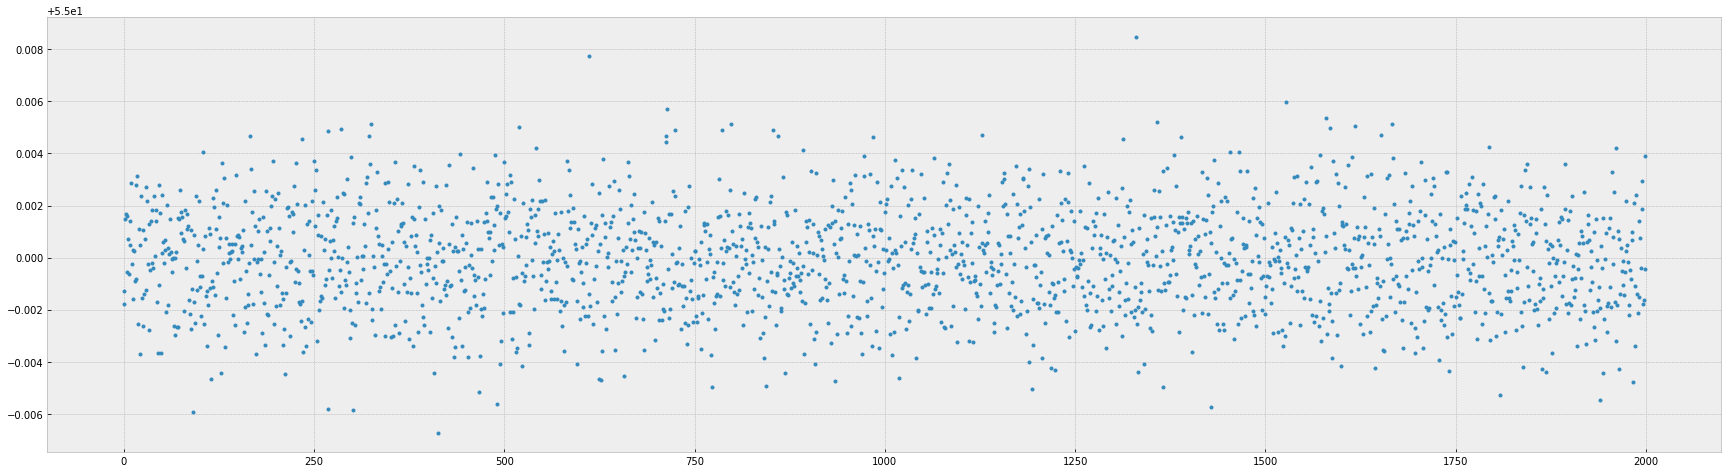

In [8]:
plt.figure(figsize=(30,8))
plt.plot(y[0:2000],'.')

In [9]:
mn = np.mean(y[0:160000])
print("Y mean:",mn)
dataset['y'] = [1 if i > mn else 0 for i in y]
dataset

Y mean: 54.99999348589188


ix        x0        x1        x2        x3        x4        x5  \
0        0  0.999896  1.000140  1.000100  0.999824  0.999870  1.000013   
1        0  0.999918  0.999819  0.999938  0.999932  1.000092  1.000139   
2        0  1.000067  0.999953  1.000049  1.000132  0.999890  1.000065   
3        0  1.000182  0.999956  1.000044  1.000123  0.999921  0.999928   
4        0  0.999856  1.000100  1.000031  0.999941  0.999973  1.000025   
...     ..       ...       ...       ...       ...       ...       ...   
999995  99  1.000124  1.000132  1.000203  1.000069  0.999974  0.999991   
999996  99  1.000008  1.000003  0.999909  1.000108  1.000039  0.999946   
999997  99  1.000167  1.000005  0.999909  1.000081  0.999846  0.999913   
999998  99  0.999905  1.000034  0.999859  0.999928  0.999988  0.999955   
999999  99  1.000099  1.000044  0.999903  1.000029  0.999981  0.999978   

              x6        x7        x8        x9  y  
0       0.999867  1.000013  0.999992  1.000140  0  
1       1.000021  1.000052  1.000158  0.999828  0  
2       1.000061  0.999978  1.000016  1.000042  1  
3       0.999926  1.000037  1.000098  0.999865  1  
4       1.000162  0.999849  0.999938  1.000119  0  
...          ...       ...       ...       ... ..  
999995  0.999934  1.000274  1.000131  1.000149  1  
999996  1.000065  0.999838  0.999859  0.999953  0  
999997  0.999982  0.999878  0.999985  1.000041  0  
999998  1.000014  0.999823  0.999749  1.000017  0  
999999  1.000074  0.999930  1.000115  0.999986  1  

[1000000 rows x 12 columns]

+ trainset에 index를 포함시킨다.
+ index는 시간의 경과에 해당되며, 이 index의 수치에 따라, p(y|x)에 대한 importance의 변화가 반영될 수 있지 않겠는가???

+ MI의 측정

In [10]:
dataset[dataset['ix'] == 0]

ix        x0        x1        x2        x3        x4        x5  \
0      0  0.999896  1.000140  1.000100  0.999824  0.999870  1.000013   
1      0  0.999918  0.999819  0.999938  0.999932  1.000092  1.000139   
2      0  1.000067  0.999953  1.000049  1.000132  0.999890  1.000065   
3      0  1.000182  0.999956  1.000044  1.000123  0.999921  0.999928   
4      0  0.999856  1.000100  1.000031  0.999941  0.999973  1.000025   
...   ..       ...       ...       ...       ...       ...       ...   
9995   0  0.999740  1.000015  0.999898  1.000231  1.000076  1.000017   
9996   0  1.000123  0.999808  0.999777  0.999984  0.999839  0.999910   
9997   0  0.999777  0.999999  0.999841  1.000163  1.000040  1.000071   
9998   0  0.999858  0.999988  0.999992  1.000045  0.999935  0.999974   
9999   0  1.000154  1.000012  0.999983  1.000100  0.999989  0.999994   

            x6        x7        x8        x9  y  
0     0.999867  1.000013  0.999992  1.000140  0  
1     1.000021  1.000052  1.000158  0.999828  0  
2     1.000061  0.999978  1.000016  1.000042  1  
3     0.999926  1.000037  1.000098  0.999865  1  
4     1.000162  0.999849  0.999938  1.000119  0  
...        ...       ...       ...       ... ..  
9995  1.000204  0.999874  1.000140  0.999930  0  
9996  1.000010  1.000040  0.999926  1.000026  0  
9997  1.000015  0.999980  0.999808  0.999798  0  
9998  1.000104  1.000046  0.999878  1.000087  0  
9999  1.000091  0.999974  1.000048  0.999976  1  

[10000 rows x 12 columns]

x0    0.087683
x1    0.072180
x2    0.056090
x3    0.043080
x4    0.025691
x6    0.021247
x5    0.016282
x9    0.005260
x7    0.003567
x8    0.002185
Name: MI Scores, dtype: float64
x0    0.087975
x1    0.068786
x2    0.057843
x3    0.047705
x4    0.027104
x5    0.017916
x6    0.010638
x7    0.005513
x9    0.002386
x8    0.002214
Name: MI Scores, dtype: float64
x0    0.083246
x1    0.068560
x2    0.064049
x3    0.037614
x5    0.025067
x4    0.022438
x6    0.013418
x8    0.013033
x7    0.008612
x9    0.000951
Name: MI Scores, dtype: float64
x0    0.086454
x1    0.074561
x2    0.058391
x3    0.045643
x4    0.034848
x5    0.024066
x6    0.020086
x7    0.013204
x9    0.000804
x8    0.000000
Name: MI Scores, dtype: float64
x0    0.089152
x1    0.071317
x2    0.047435
x3    0.034711
x4    0.034094
x6    0.021428
x7    0.016120
x5    0.014990
x8    0.008877
x9    0.000000
Name: MI Scores, dtype: float64
x0    0.088827
x1    0.064306
x2    0.060598
x3    0.046927
x4    0.033814
x5    0.017729


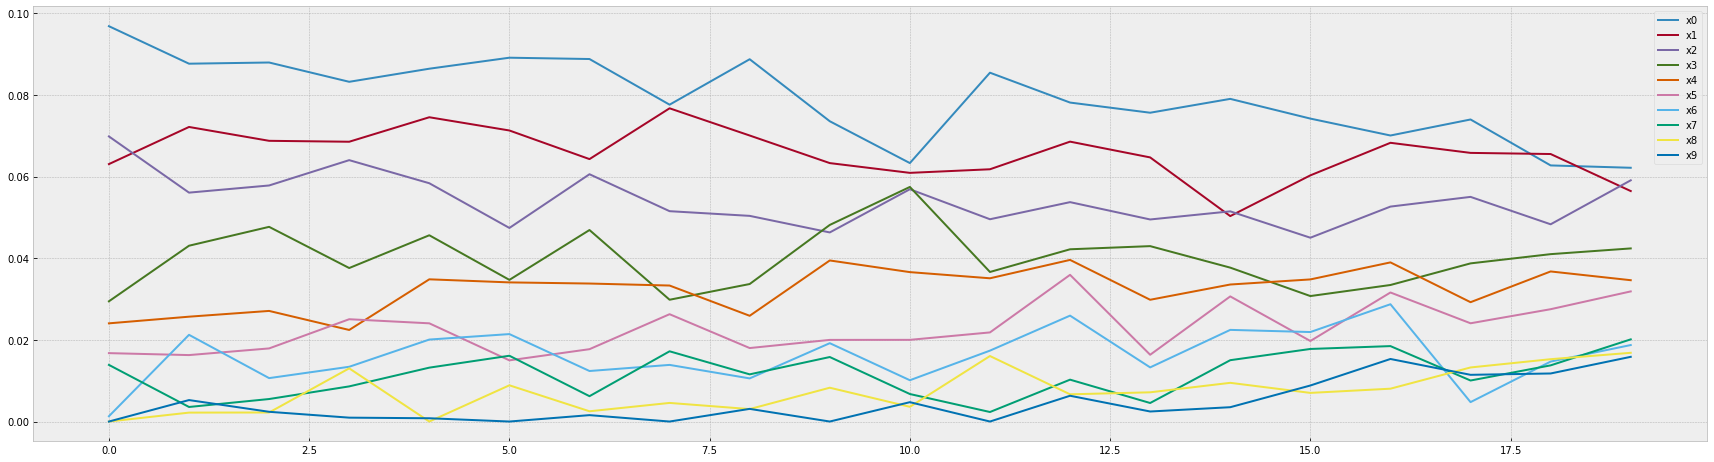

In [11]:
i=0
mi_scores = make_mi_scores(dataset[dataset['ix'] == 0][COLUMNS], dataset[dataset['ix'] == 0]['y'], discrete_features="auto")
imp_df_mi = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
for i in range(1,20):
    mi_scores = make_mi_scores(dataset[dataset['ix'] == i][COLUMNS], dataset[dataset['ix'] == i]['y'], discrete_features="auto")
    print(mi_scores)
    tmp_df = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
    imp_df_mi.loc[len(imp_df_mi)] = tmp_df.values.reshape(-1,)

imp_df_mi.plot(figsize=(30,8))

+ Random-forest로 학습한다.
+ ix (시간의 경과)에 따른 importance가 내포 될 수 있을까?
+ 구조적으로 안될 것 같은데....

In [12]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

trainset = dataset[0:160000][COLUMNS].values
train_y = dataset[0:160000]['y'].values

business_model = RandomForestClassifier(n_estimators=80,max_depth=5)
business_model.fit(trainset,train_y)

testset = dataset[160000:200000][COLUMNS].values
test_y = dataset[160000:200000]['y'].values
base_score = precision_recall_fscore_support(test_y, business_model.predict(testset),average='binary')
base_score

(0.5802594368621665, 0.941449304274101, 0.7179887035733983, None)

In [13]:
mi_scores = make_mi_scores(dataset[0:160000][COLUMNS], train_y, discrete_features="auto")
print(mi_scores)

x0    0.082629
x1    0.065591
x2    0.053066
x3    0.044476
x4    0.030553
x5    0.021995
x6    0.016065
x7    0.011089
x9    0.004837
x8    0.004220
Name: MI Scores, dtype: float64


#MINE

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [52]:
data_size = 20000
cor = [0.5, 1, 1.5, 2, 2.5]

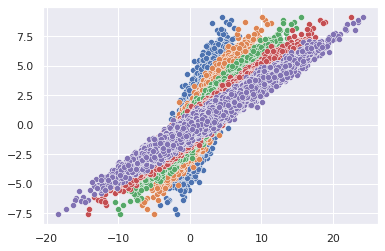

In [56]:
y= np.random.normal(1,2,data_size)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y*cor_ + np.random.normal(1,1,data_size)
    sns.scatterplot(x=x[:,ix],y=y)

In [57]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [58]:
mi_scores = make_mi_scores(pd.DataFrame(x,columns=['x0','x1','x2','x3','x4']), y, discrete_features="auto")
print(mi_scores)

x4    1.646847
x3    1.428935
x2    1.162214
x1    0.823162
x0    0.360800
Name: MI Scores, dtype: float64


In [17]:
x = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0],[0,1]],
                                 size = 300)

In [18]:
y = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0.8],[0.8,1]],
                                 size = 300)

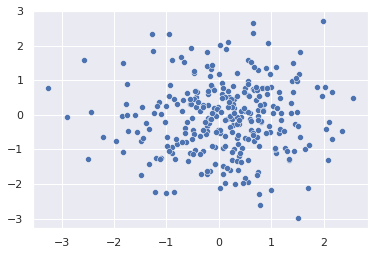

In [19]:
# plt indep Gaussian
sns.scatterplot(x=x[:,0],y=x[:,1])

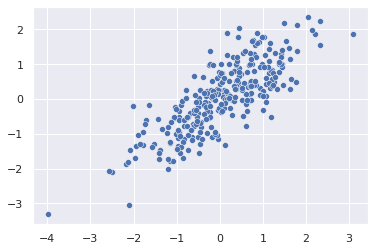

In [20]:
# plt cor Gaussian
sns.scatterplot(x=y[:,0],y=y[:,1])

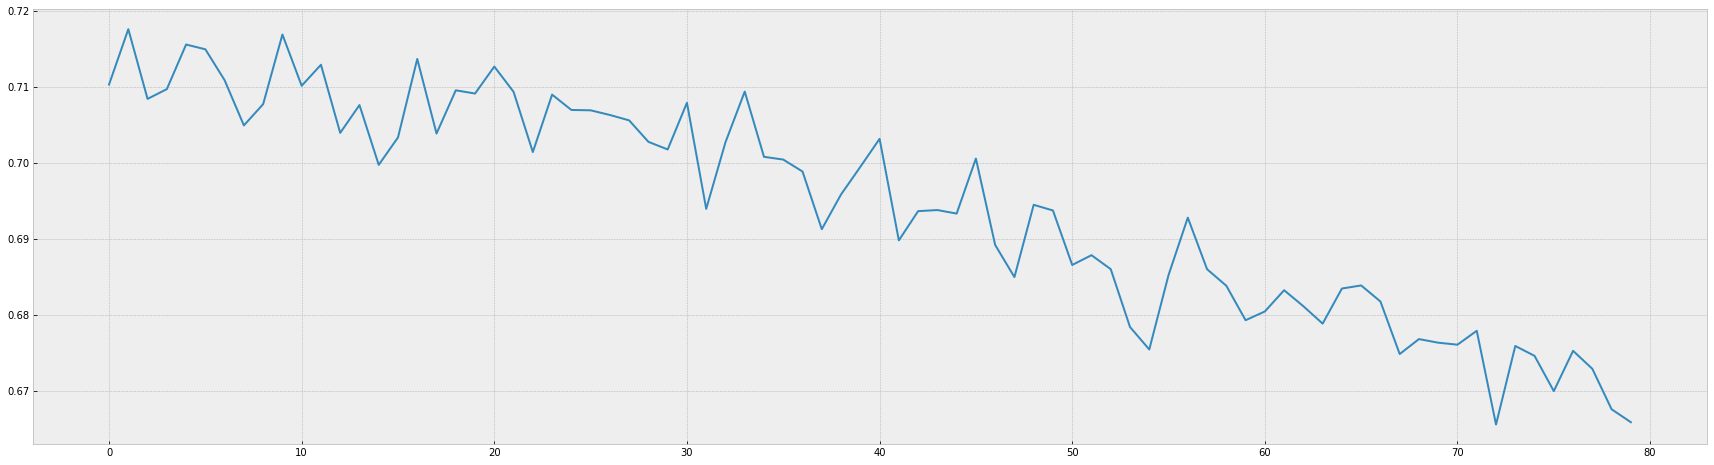

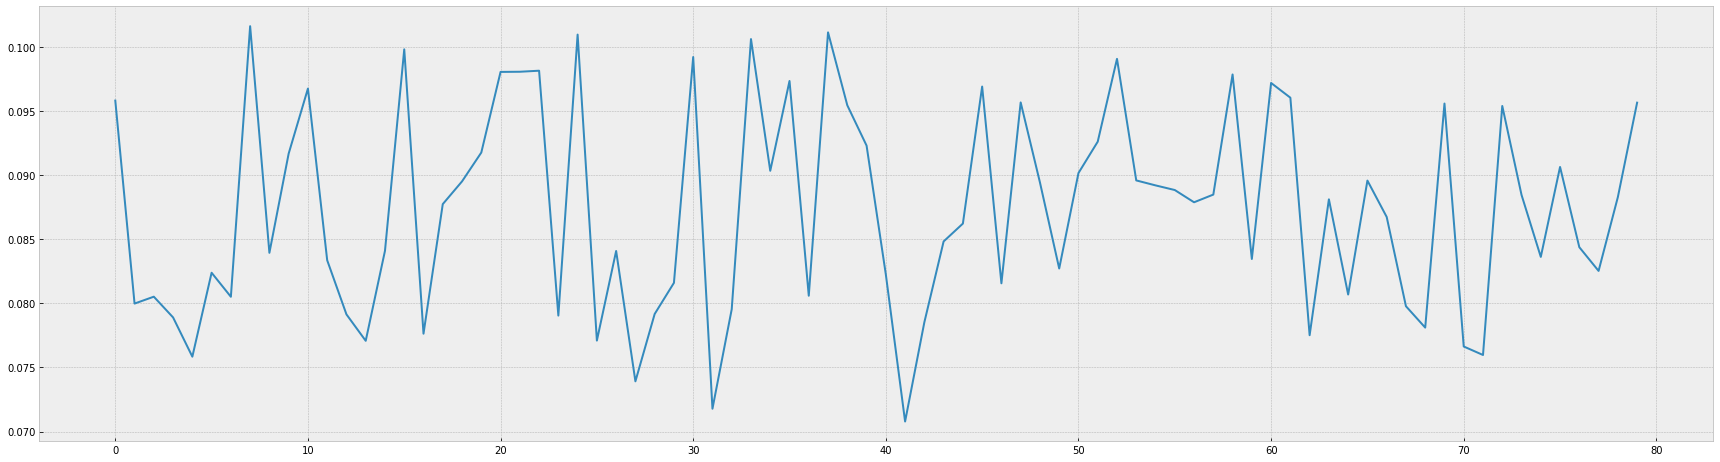

In [ ]:
import math

#X2 = dataset[200000:].drop(columns=['y']).values
#Y2 = dataset[200000:]['y'].values

result = {}
result['precision'] = []
result['predicted'] = []
result['drift'] = []
#window_size = 10000
#step = 5000
#predicted = 0
#batch = math.ceil((X2.shape[0]-window_size)/step)
for i in range(20,100):
    ux = dataset[dataset['ix'] == i][COLUMNS].values #X2[i*step:i*step+window_size]
    uy = dataset[dataset['ix'] == i]['y'].values #Y2[i*step:i*step+window_size]
    f1 = precision_recall_fscore_support(uy, business_model.predict(ux),average='binary')
    drift = __ks_drift(trainset,ux)
    result['precision'].append(f1[2])
    result['predicted'].append(0.0)
    result['drift'].append(sum(abs(drift[:,0])))

result_df = pd.DataFrame(result)
result_df['precision'].plot(figsize=(30,8))
plt.show()
result_df['drift'].plot(figsize=(30,8))
plt.show()
     

In [ ]:
np.zeros((1,10))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
import math
from scipy.special import rel_entr

result = {}
result['precision'] = []
#result['sub_precision'] = []
#result['y_-y__'] = []
result['drift'] = []

drifts = {}
for f in range(10):
    drifts[f'x{f}'] = []

#MI
mi_scores = make_mi_scores(pd.DataFrame(trainset[:,0:10],columns=COLUMNS), train_y, discrete_features="auto")
print(mi_scores.values.reshape(1,-1))
imp_df_mi = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
imp_df_mi2 = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
#imp_df_mi3 = pd.DataFrame(np.zeros((1,10)),columns=list(mi_scores.keys()))[COLUMNS]
#window_size = 10000
#step = 5000
#predicted = 0
#batch = math.ceil((X2.shape[0]-window_size)/step)
for i in range(20,100):
    ux = dataset[dataset['ix'] == i][COLUMNS].values #X2[i*step:i*step+window_size]
    uy = dataset[dataset['ix'] == i]['y'].values #Y2[i*step:i*step+window_size]
    y_ = business_model.predict(ux)
    #y__ = sub_business_model.predict(ux[500:])
    f1 = precision_recall_fscore_support(uy,y_ ,average='binary')
    #f1_ = precision_recall_fscore_support(uy[0:500],y__ ,average='binary')
    drift = __ks_drift(trainset[:,0:10],ux[:,0:10])
    result['precision'].append(f1[2])
    #result['sub_precision'].append(f1_[0])
    ## KL divergence 
    #result['y_-y__'].append(np.std(y_) - np.std(y__))
    result['drift'].append(sum(abs(drift[:,0])))
    for idx, dv in enumerate(drift[:,0]):
        if idx < 10:
            drifts[f'x{idx}'].append(dv)    
            
    #MI
    mi_scores = make_mi_scores(pd.DataFrame(ux[:,0:10],columns=COLUMNS), uy, discrete_features="auto")
    tmp_df = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
    imp_df_mi.loc[len(imp_df_mi)] = tmp_df.values.reshape(-1,)

    #PMI
    mi_scores = make_mi_scores(pd.DataFrame(ux[:,0:10],columns=COLUMNS), y_, discrete_features="auto")
    tmp_df = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
    imp_df_mi2.loc[len(imp_df_mi2)] = tmp_df.values.reshape(-1,)

    
    print(f"\r{i+1}/{batch} f1:{f1[2]:.4f}", end="", flush=True)


[[0.08253668 0.06560014 0.05294638 0.04433355 0.03030192 0.02211685
  0.01591512 0.01084788 0.00488426 0.00427341]]
100/158 f1:0.6659

[]

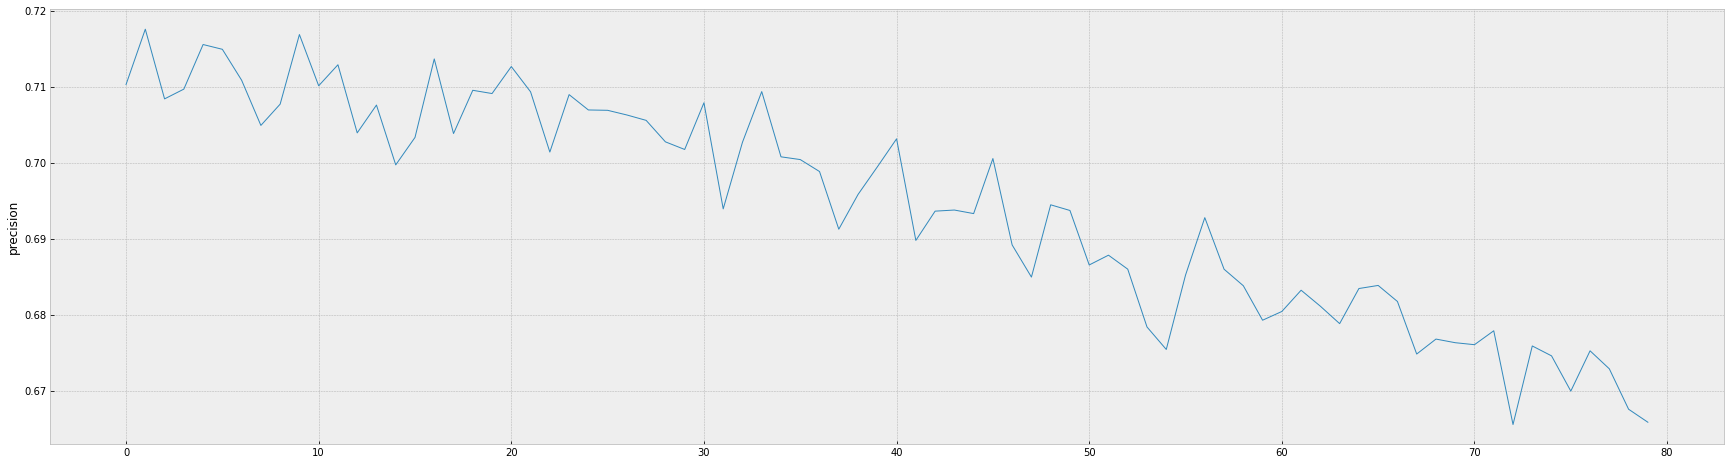

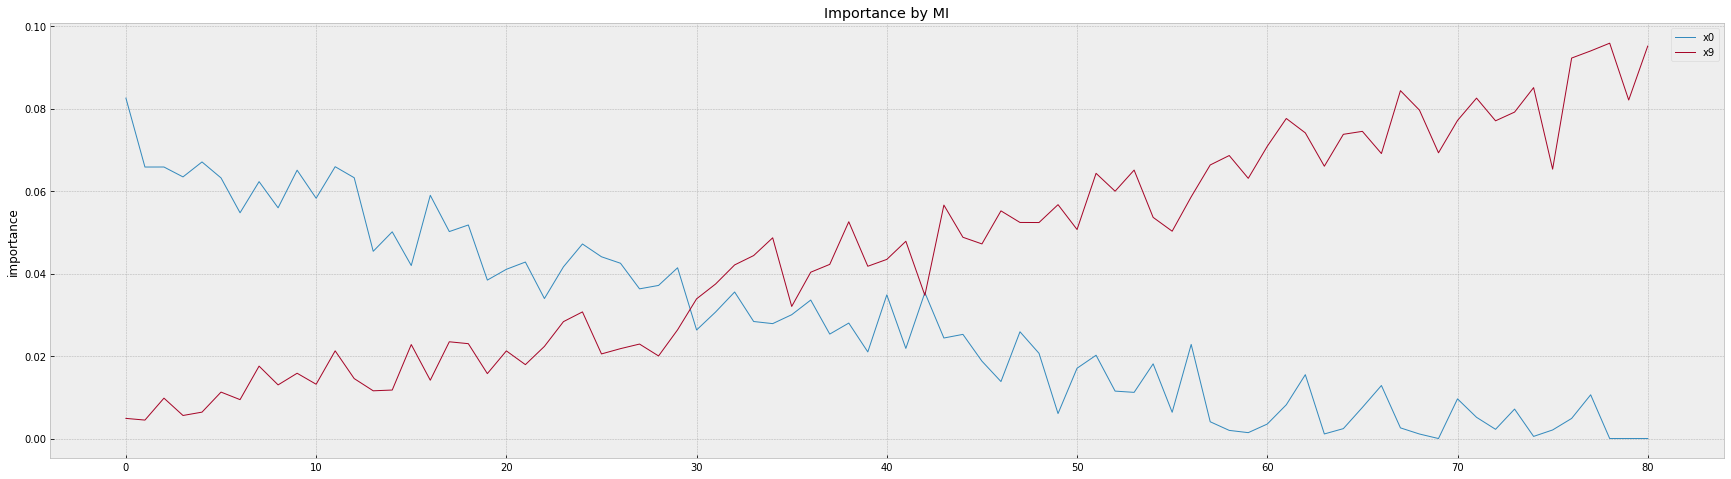

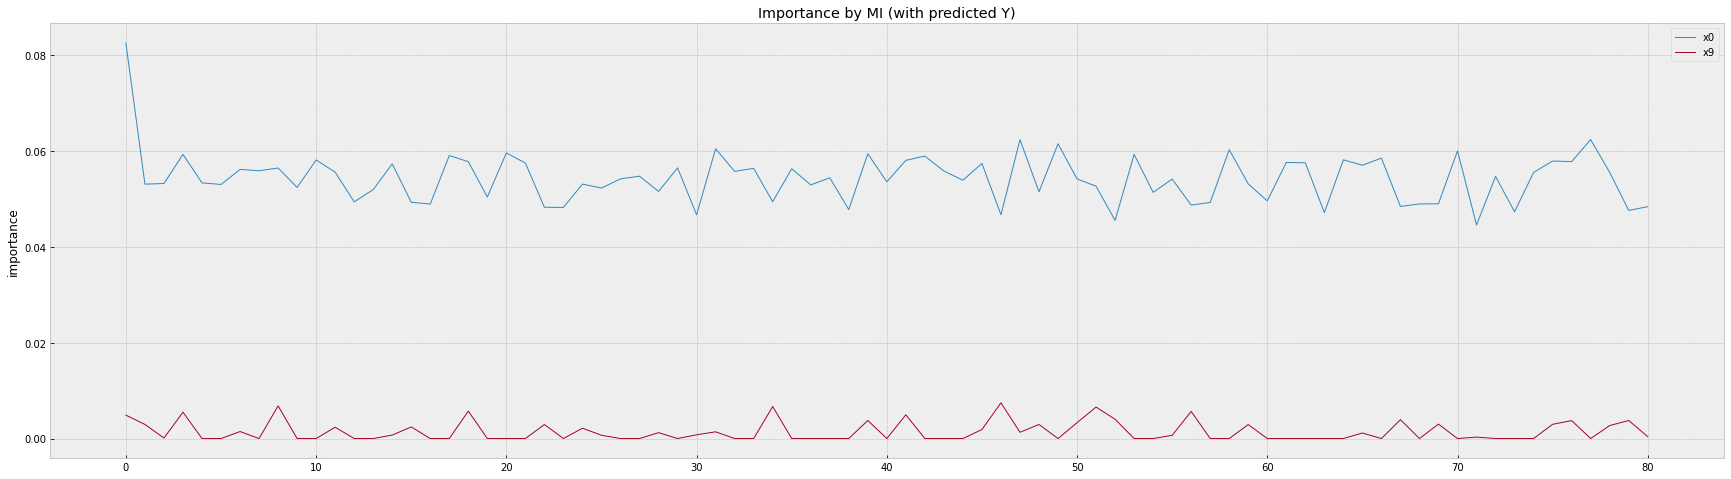

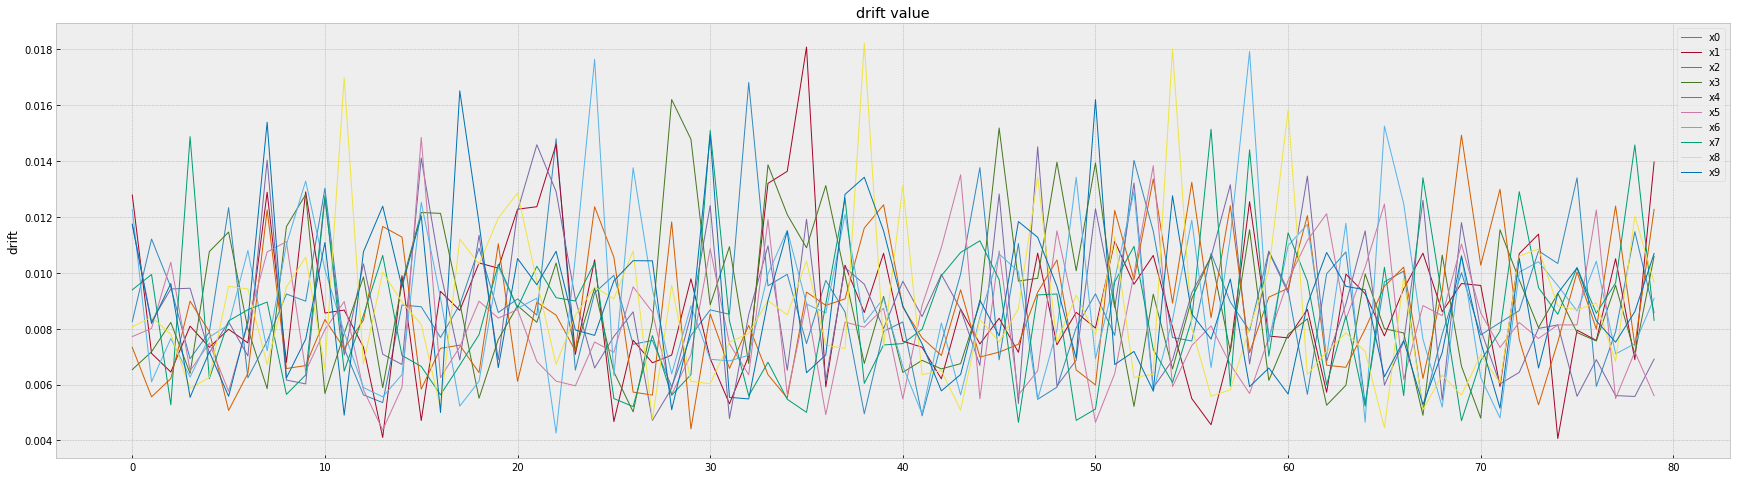

In [ ]:
plt.style.use('bmh')

result_df = pd.DataFrame(result)
#result_df[['precision','sub_precision']].plot(ylabel='precision',linewidth=1,figsize=(30,8))
result_df['precision'].plot(ylabel='precision',linewidth=1,figsize=(30,8))

#result_df[['y_-y__']].plot(ylabel='delta Y',linewidth=1,figsize=(30,8))


ax = imp_df_mi[['x0','x9']].plot(ylabel='importance',linewidth=1,figsize=(30,8),legend=True)
ax.set_title("Importance by MI",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

ax = imp_df_mi2[['x0','x9']].plot(ylabel='importance',linewidth=1,figsize=(30,8),legend=True)
ax.set_title("Importance by MI (with predicted Y)",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

'''
ax = imp_df_mi3.plot(ylabel='importance',linewidth=1,figsize=(30,8),legend=True)
ax.set_title("Importance by MI (with predicted Y from sub model)",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()
'''

tmp_df = pd.DataFrame(drifts)

ax = tmp_df.plot(ylabel='drift',linewidth=1,figsize=(30,8),legend=True)
ax.set_title("drift value",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

### 결론

역시, ix의 변화에 따른 importance의 변화는 학습되지 못 했다.

### Deep architecture에 의한 importance의 변화 반영 여부 실험!

In [ ]:

def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])
     

In [ ]:
import os.path 

scaler = MinMaxScaler()
x_train = scaler.fit_transform(trainset)
y_train = get_one_hot(train_y ,2)

# building the model

from keras.models import Model   
from keras.layers import * 

inputs = Input(shape=(10,)) # input tensor
hidden1 = Dense(units=40,activation='relu')(inputs) # hidden layer 1
hidden2 = Dense(units=20,activation='relu')(hidden1) # hidden layer 2
outputs = Dense(units=2,activation='softmax')(hidden2) # hidden layer 1


#define the model's start and end points    
model = Model(inputs, outputs)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(x=x_train, 
        y=y_train, 
        epochs=30,
        batch_size=1000,
        verbose=1)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_15 (Dense)            (None, 40)                440       
                                                                 
 dense_16 (Dense)            (None, 20)                820       
                                                                 
 dense_17 (Dense)            (None, 2)                 42        
                                                                 
Total params: 1,302
Trainable params: 1,302
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
160/160 [==============================] - 1s 3ms/step - loss: 0.6538 - accuracy: 0.6430
Epoch 2/30
160/160 [==============================] - 0s 3ms/step - loss: 0.4734 - a

In [ ]:
model.layers[1].get_weights()[1].shape

(40,)

In [ ]:
for i in range(10):
    print(np.sum(model.layers[1].get_weights()[1][i,:]))


IndexError: ignored

In [ ]:

Y3_ = model.predict(scaler.transform(testset),verbose=0)
Y4_ = np.asarray([1 if _Y[1] > 0.5 else 0 for _Y in Y3_])

base_score = precision_recall_fscore_support(test_y, Y4_,average='binary')
base_score

(0.9705649157581764, 0.9768091367014115, 0.9736770152370063, None)

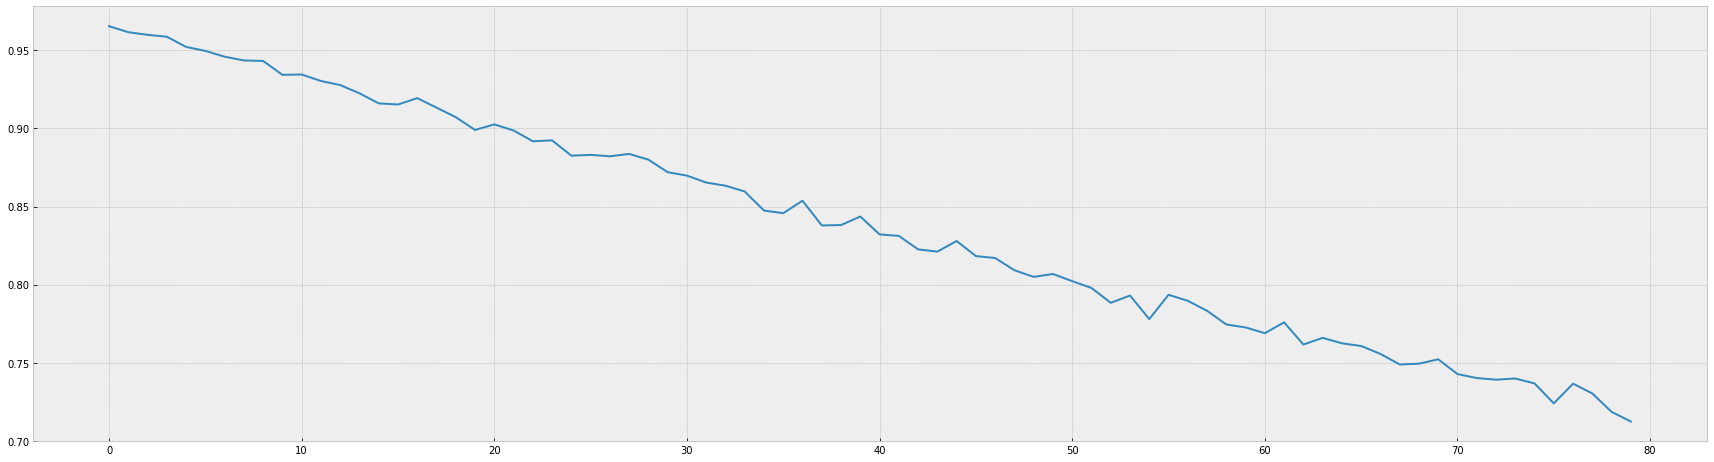

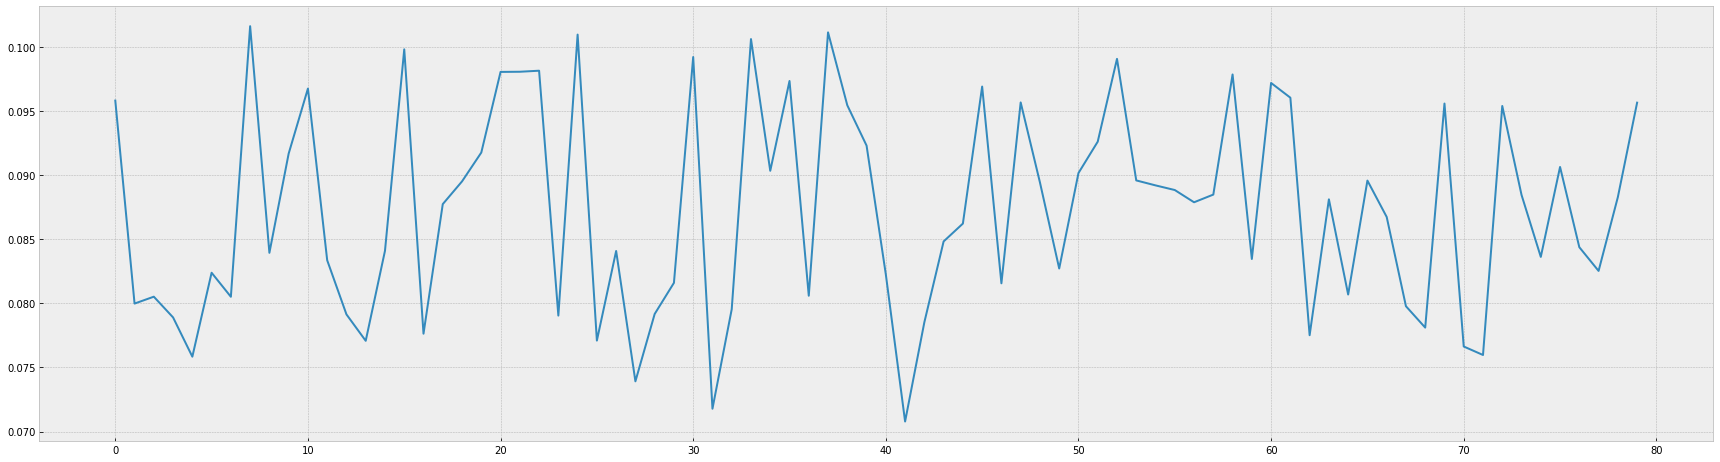

In [ ]:
import math 

#X2 = dataset[10000:].drop(columns=['y']).values
#Y2 = dataset[10000:]['y'].values

result = {}
result['precision'] = []
result['predicted'] = []
result['drift'] = []
#window_size = 8000
#step = 500
#predicted = 0
#batch = math.ceil((X2.shape[0]-window_size)/step)
for i in range(20,100):
    ux = dataset[dataset['ix'] == i][COLUMNS].values #X2[i*step:i*step+window_size]
    uy = dataset[dataset['ix'] == i]['y'].values #Y2[i*step:i*step+window_size]

    Y3_ = model.predict(scaler.transform(ux),verbose=0)
    Y4_ = np.asarray([1 if _Y[1] > 0.5 else 0 for _Y in Y3_])

    f1 = precision_recall_fscore_support(uy, Y4_,average='binary')

    #f1 = precision_recall_fscore_support(uy, business_model.predict(ux),average='binary')
    drift = __ks_drift(trainset[:,0:10],ux[:,0:10])
    result['precision'].append(f1[2])
    result['predicted'].append(0.0)
    result['drift'].append(sum(abs(drift[:,0])))

result_df = pd.DataFrame(result)
result_df['precision'].plot(figsize=(30,8))
plt.show()
result_df['drift'].plot(figsize=(30,8))
plt.show()

+ ix 적용 비교...

In [ ]:
# 클수로... 시간요소가 작아진다.
gamma = 95

### ix 적용 실험

In [ ]:
trainset = dataset[0:160000][COLUMNS+['ix']].values
train_y = dataset[0:160000]['y'].values
trainset[:,10] = trainset[:,10]/gamma
testset = dataset[160000:200000][COLUMNS+['ix']].values
test_y = dataset[160000:200000]['y'].values
testset[:,10] = testset[:,10]/gamma

In [ ]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(trainset)
x_train[:,10] = trainset[:,10]
y_train = get_one_hot(train_y ,2)

inputs = Input(shape=(11,)) # input tensor
hidden1 = Dense(units=44,activation='relu')(inputs) # hidden layer 1
hidden2 = Dense(units=20,activation='relu')(hidden1) # hidden layer 2
outputs = Dense(units=2,activation='softmax')(hidden2) # hidden layer 1
#define the model's start and end points    
model = Model(inputs, outputs)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(x=x_train, 
        y=y_train, 
        epochs=30,
        batch_size=1000,
        verbose=1)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 11)]              0         
                                                                 
 dense_36 (Dense)            (None, 44)                528       
                                                                 
 dense_37 (Dense)            (None, 20)                900       
                                                                 
 dense_38 (Dense)            (None, 2)                 42        
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
160/160 [==============================] - 1s 3ms/step - loss: 0.6607 - accuracy: 0.6209
Epoch 2/30
160/160 [==============================] - 0s 3ms/step - loss: 0.4838 - a

In [ ]:
test_x = scaler.transform(testset)
test_x[:,10] = testset[:,10]

In [ ]:
Y3_ = model.predict(test_x,verbose=0)
Y4_ = np.asarray([1 if _Y[1] > 0.5 else 0 for _Y in Y3_])

base_score = precision_recall_fscore_support(test_y, Y4_,average='binary')
base_score

(0.9795619701251513, 0.9680813924492544, 0.9737878445832392, None)

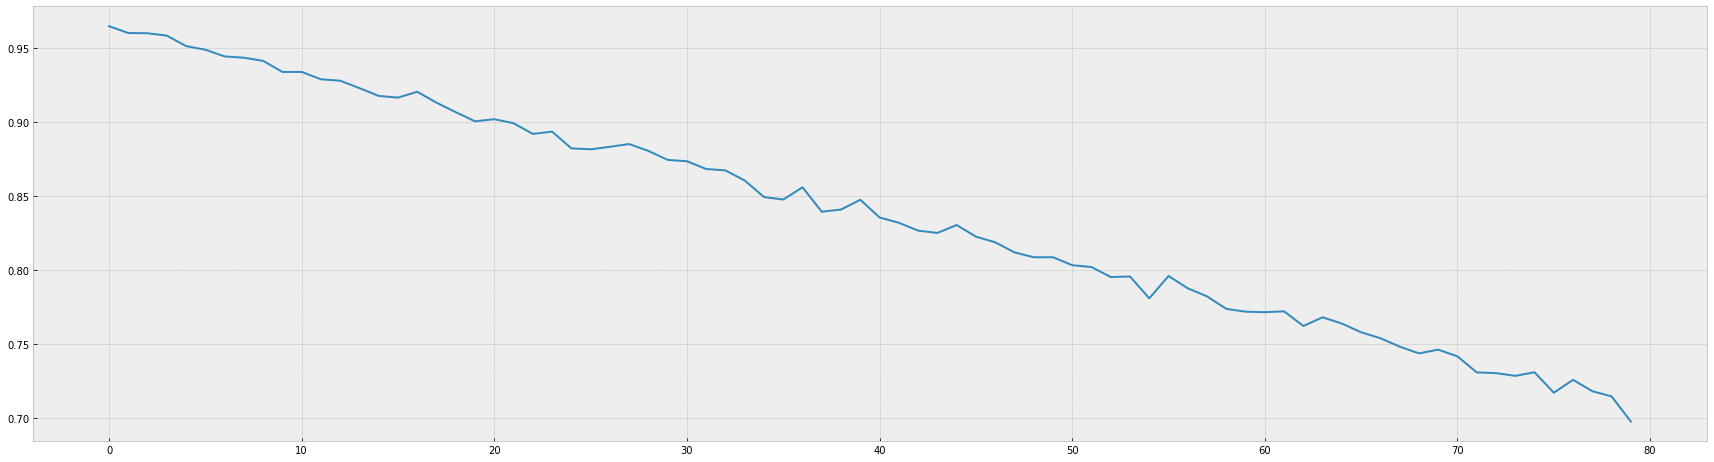

In [ ]:

result = {}
result['precision'] = []
result['predicted'] = []
#result['drift'] = []
#window_size = 8000
#step = 500
#predicted = 0
#batch = math.ceil((X2.shape[0]-window_size)/step)
for i in range(20,100):
    ux = dataset[dataset['ix'] == i][COLUMNS+['ix']].values #X2[i*step:i*step+window_size]
    uy = dataset[dataset['ix'] == i]['y'].values #Y2[i*step:i*step+window_size]
    ux_ = scaler.transform(ux)
    ux_[:,10] = ux[:,10]/gamma
    Y3_ = model.predict(ux_,verbose=0)
    Y4_ = np.asarray([1 if _Y[1] > 0.5 else 0 for _Y in Y3_])
    f1 = precision_recall_fscore_support(uy, Y4_,average='binary')

    #f1 = precision_recall_fscore_support(uy, business_model.predict(ux),average='binary')
    #drift = __ks_drift(trainset[:,0:10],ux[:,0:10])
    result['precision'].append(f1[2])
    result['predicted'].append(0.0)
    #result['drift'].append(sum(abs(drift[:,0])))

result_df = pd.DataFrame(result)
result_df['precision'].plot(figsize=(30,8))
plt.show()


### 다음 step

In [ ]:
import math
from scipy.special import rel_entr

result = {}
result['precision'] = []
#result['sub_precision'] = []
#result['y_-y__'] = []
result['drift'] = []

drifts = {}
for f in range(10):
    drifts[f'x{f}'] = []

#MI
mi_scores = make_mi_scores(pd.DataFrame(trainset[:,0:10],columns=COLUMNS), train_y, discrete_features="auto")
print(mi_scores.values.reshape(1,-1))
imp_df_mi = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
imp_df_mi2 = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
#imp_df_mi3 = pd.DataFrame(np.zeros((1,10)),columns=list(mi_scores.keys()))[COLUMNS]
window_size = 1000
step = 500
predicted = 0
batch = math.ceil((X2.shape[0]-window_size)/step)
for i in range(batch):
    ux = X2[i*step:i*step+window_size]
    uy = Y2[i*step:i*step+window_size]
    ux_ = scaler.transform(ux)
    ux_[:,10] = ux[:,10]    
    Y3_ = model.predict(ux_,verbose=0)
    Y4_ = np.asarray([1 if _Y[1] > 0.5 else 0 for _Y in Y3_])
    #y__ = sub_business_model.predict(ux[500:])
    f1 = precision_recall_fscore_support(uy,Y4_ ,average='binary')
    #f1_ = precision_recall_fscore_support(uy[0:500],y__ ,average='binary')
    #drift = __ks_drift(trainset,ux)
    drift = __ks_drift(trainset[:,0:10],ux[:,0:10])
    result['precision'].append(f1[2])
    #result['sub_precision'].append(f1_[0])
    ## KL divergence 
    #result['y_-y__'].append(np.std(y_) - np.std(y__))
    result['drift'].append(sum(abs(drift[:,0])))
    for idx, dv in enumerate(drift[:,0]):
        drifts[f'x{idx}'].append(dv)    
            
    #MI
    mi_scores = make_mi_scores(pd.DataFrame(ux[:,0:10],columns=COLUMNS), uy, discrete_features="auto")
    tmp_df = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
    imp_df_mi.loc[len(imp_df_mi)] = tmp_df.values.reshape(-1,)

    #PMI
    mi_scores = make_mi_scores(pd.DataFrame(ux[:,0:10],columns=COLUMNS), Y4_, discrete_features="auto")
    tmp_df = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
    imp_df_mi2.loc[len(imp_df_mi2)] = tmp_df.values.reshape(-1,)

    
    print(f"\r{i+1}/{batch} f1:{f1[2]:.4f}", end="", flush=True)


[[0.09141603 0.0909163  0.08469528 0.03749834 0.035839   0.02363077
  0.02011068 0.01872192 0.01768245 0.01684535]]
72/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


73/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


74/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


75/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


78/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


79/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


80/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


81/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


82/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


85/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


86/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


87/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


88/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


89/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


90/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


91/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


92/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


93/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


94/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


96/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


97/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


98/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


99/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


100/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


101/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


102/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


103/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


104/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


105/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


106/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


107/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


108/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


109/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


110/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


111/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


112/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


113/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


114/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


115/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


116/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


117/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


118/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


119/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


120/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


122/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


123/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


124/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


125/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


126/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


127/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


128/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


129/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


130/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


131/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


132/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


133/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


134/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


135/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


136/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


137/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


138/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


139/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


140/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


141/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


142/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


143/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


144/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


145/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


146/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


147/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


148/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


149/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


150/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


151/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


152/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


153/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


154/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


155/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


156/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


157/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


158/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


159/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


161/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


162/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


163/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


164/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


165/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


166/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


167/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


168/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


169/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


170/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


171/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


172/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


173/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


174/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


175/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


176/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


177/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


178/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


179/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


180/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


181/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


182/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


183/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


184/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


185/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


186/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


187/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


188/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


189/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


191/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


192/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


193/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


194/194 f1:0.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
len(drifts['x9'])

194

[]

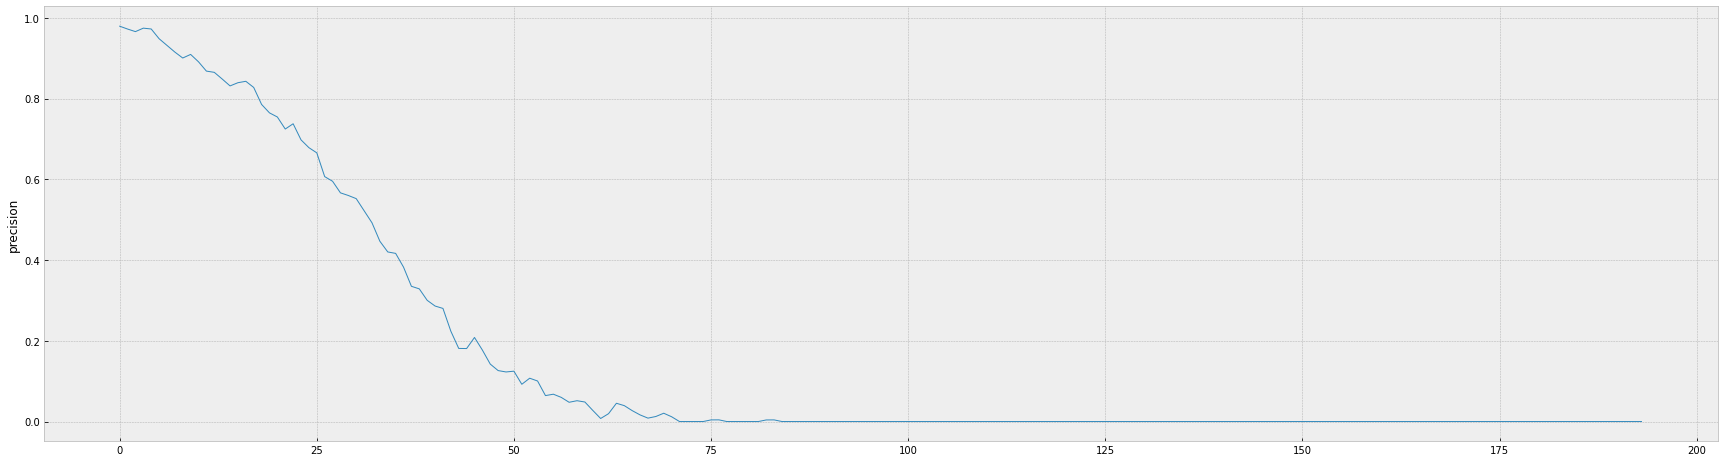

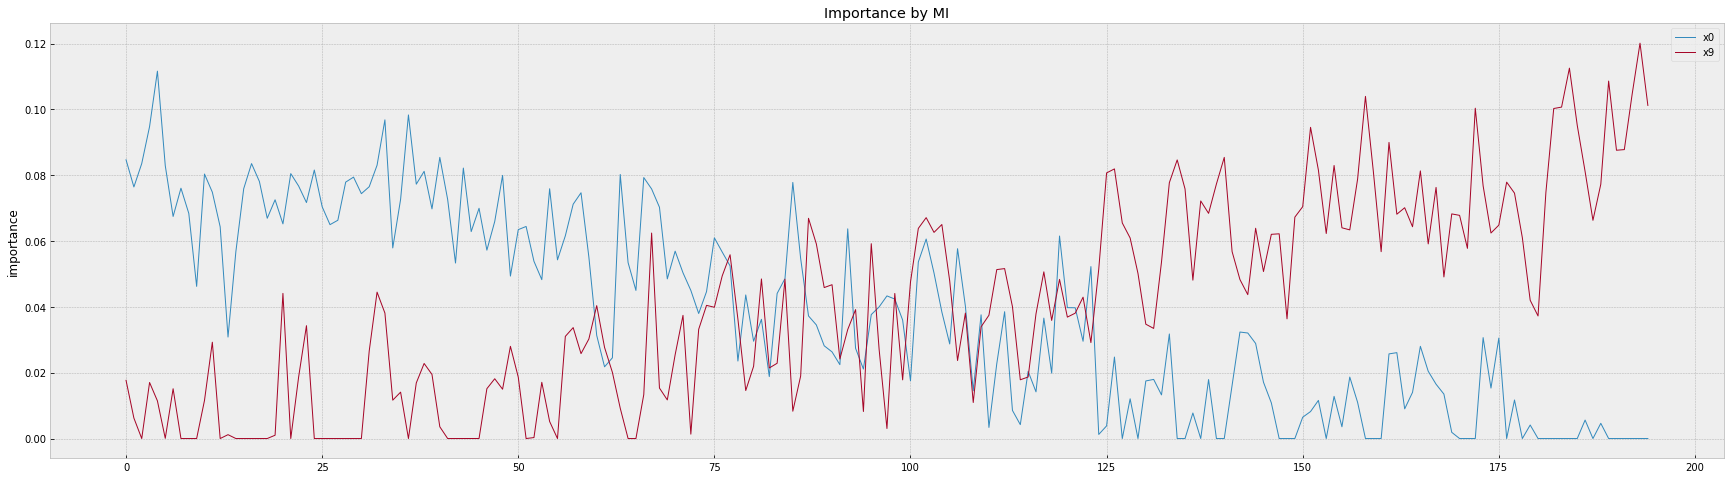

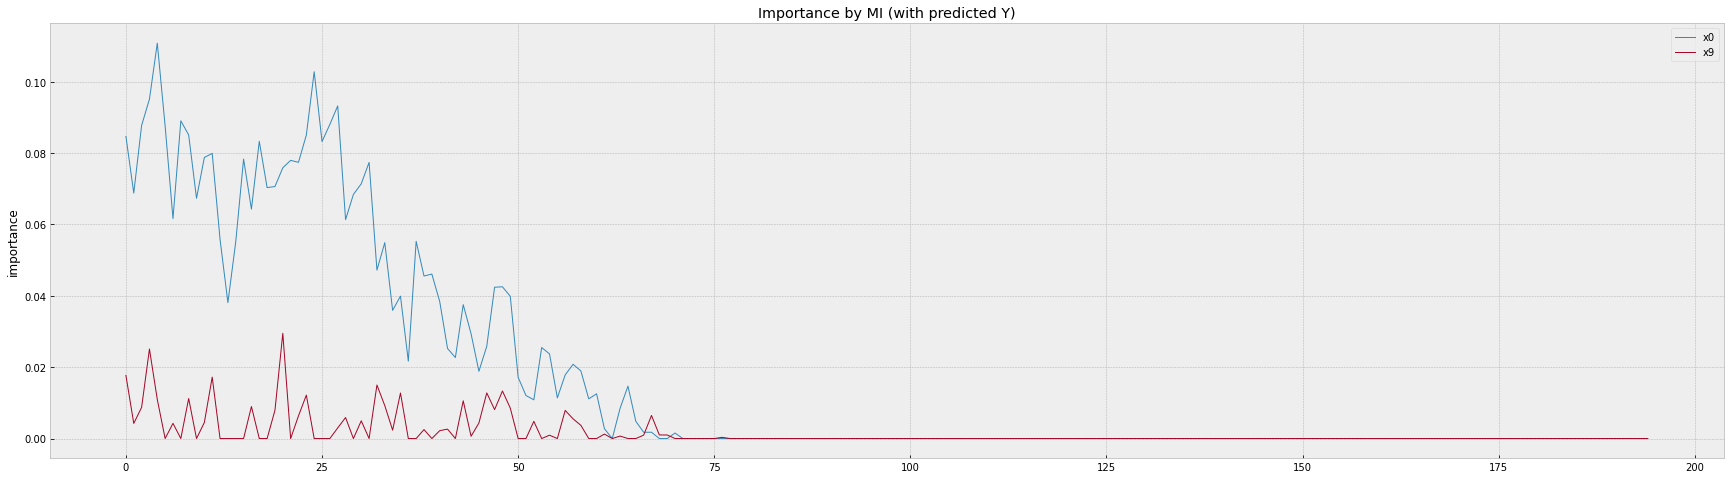

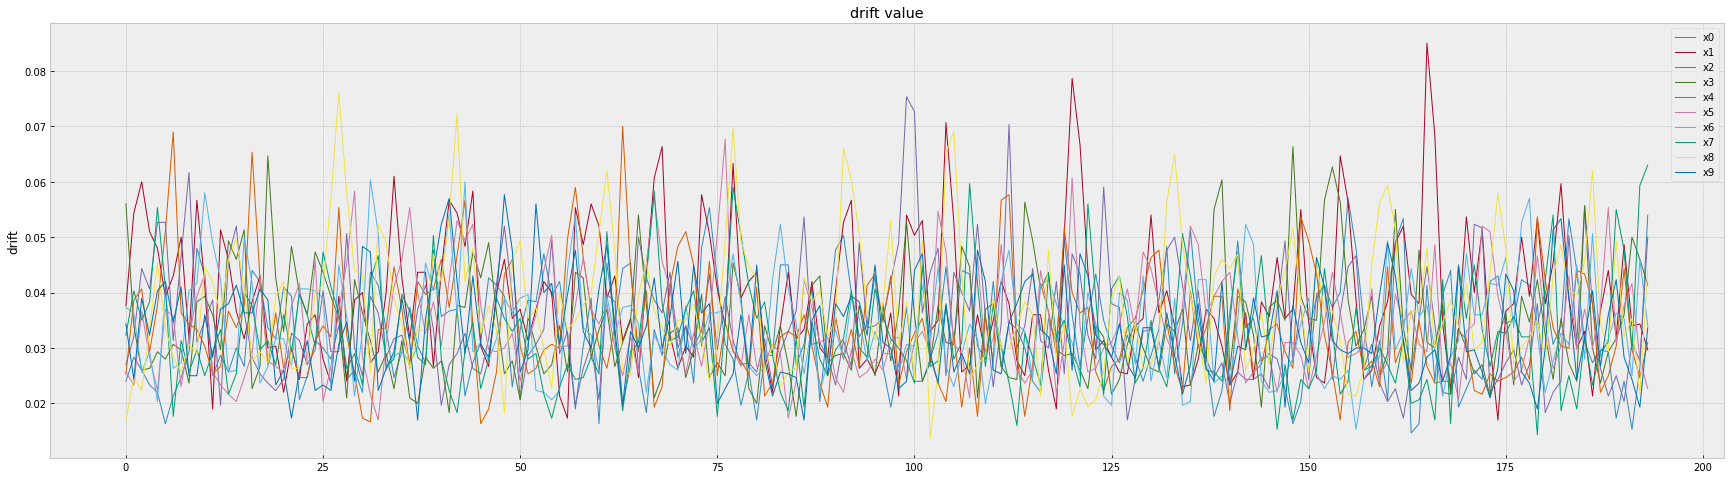

In [ ]:
plt.style.use('bmh')

result_df = pd.DataFrame(result)
#result_df[['precision','sub_precision']].plot(ylabel='precision',linewidth=1,figsize=(30,8))
result_df['precision'].plot(ylabel='precision',linewidth=1,figsize=(30,8))

#result_df[['y_-y__']].plot(ylabel='delta Y',linewidth=1,figsize=(30,8))


ax = imp_df_mi[['x0','x9']].plot(ylabel='importance',linewidth=1,figsize=(30,8),legend=True)
ax.set_title("Importance by MI",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

ax = imp_df_mi2[['x0','x9']].plot(ylabel='importance',linewidth=1,figsize=(30,8),legend=True)
#ax = imp_df_mi2.plot(ylabel='importance',linewidth=1,figsize=(30,8),legend=True)
ax.set_title("Importance by MI (with predicted Y)",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

'''
ax = imp_df_mi3.plot(ylabel='importance',linewidth=1,figsize=(30,8),legend=True)
ax.set_title("Importance by MI (with predicted Y from sub model)",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()
'''

tmp_df = pd.DataFrame(drifts)

ax = tmp_df.plot(ylabel='drift',linewidth=1,figsize=(30,8),legend=True)
ax.set_title("drift value",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

[]

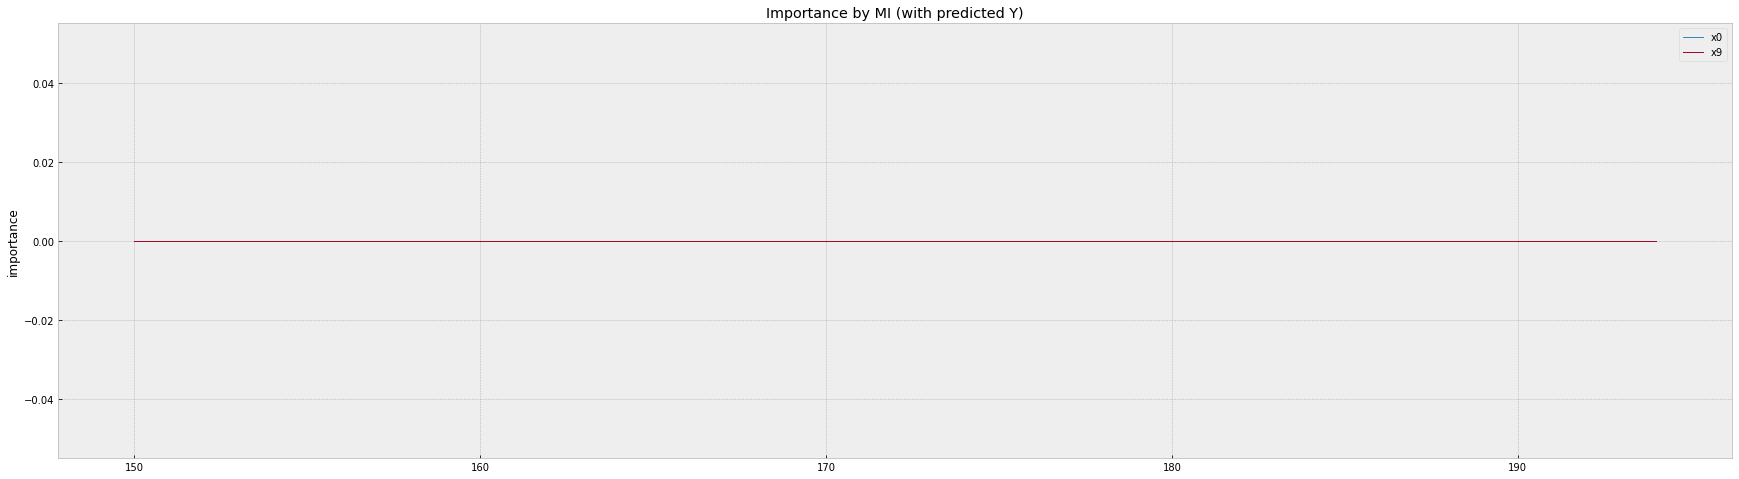

In [ ]:
ax = imp_df_mi2[['x0','x9']][150:200].plot(ylabel='importance',linewidth=1,figsize=(30,8),legend=True)
ax.set_title("Importance by MI (with predicted Y)",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

# MINE: Mutual Information Neural Estimation
+ https://github.com/MasanoriYamada/Mine_pytorch/blob/master/mine.ipynb

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
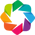

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import holoviews as hv
import bokeh
hv.extension('bokeh')

In [ ]:
%env HV_DOC_HTML=true

env: HV_DOC_HTML=true


In [ ]:
import numpy as np

# data
var = 0.2
def func(x):
    return x

def gen_x():
    return np.sign(np.random.normal(0.,1.,[data_size,1]))

def gen_y(x):
    return func(x)+np.random.normal(0.,np.sqrt(var),[data_size,1])

calculate mutual information using traditional method

In [ ]:
data_size = 1000000
x=gen_x()
y=gen_y(x)
p_y_x=np.exp(-(y-x)**2/(2*var))
p_y_x_minus=np.exp(-(y+1)**2/(2*var))
p_y_x_plus=np.exp(-(y-1)**2/(2*var))
mi=np.average(np.log(p_y_x/(0.5*p_y_x_minus+0.5*p_y_x_plus)))
mi

0.6584456214734289

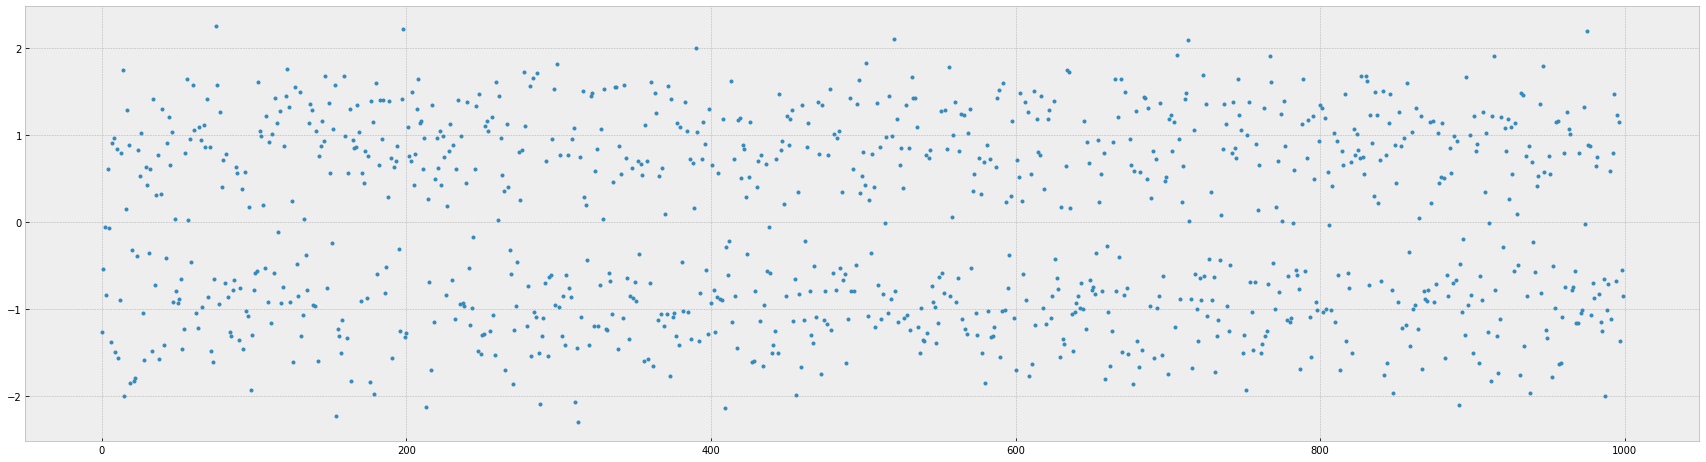

In [ ]:
plt.figure(figsize=(30,8))
plt.plot(y[0:1000],'.')

MINE

In [ ]:
H=10
n_epoch = 500
data_size = 20000
minibatch = 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(5, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 5)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2    

model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
plot_loss = []

for epoch in tqdm(range(n_epoch)):
    x_sample=gen_x()
    y_sample=gen_y(x_sample)
    y_shuffle=np.random.permutation(y_sample)
    
    s = np.random.choice(x.shape[0],minibatch)

    x_sample = Variable(torch.from_numpy(x_sample).type(torch.FloatTensor), requires_grad = True)
    y_sample = Variable(torch.from_numpy(y_sample).type(torch.FloatTensor), requires_grad = True)
    y_shuffle = Variable(torch.from_numpy(y_shuffle).type(torch.FloatTensor), requires_grad = True)    
    
    pred_xy = model(x_sample, y_sample)
    pred_x_y = model(x_sample, y_shuffle)

    ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
    loss = - ret  # maximize
    plot_loss.append(loss.data.numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()

print(loss)

100%|██████████| 500/500 [00:03<00:00, 129.44it/s]

tensor(-0.6610, grad_fn=<NegBackward0>)


Traditional VS Mine

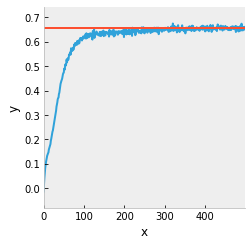

OverlayPlot(apply_extents=True, apply_ranges=True, apply_ticks=True, aspect='square', batched=False, bgcolor=None, data_aspect=None, default_span=2.0, fig_alpha=1.0, fig_bounds=(0.15, 0.15, 0.85, 0.85), fig_inches=4.0, fig_latex=False, fig_rcparams={}, fig_size=100.0, finalize_hooks=[], fontscale=None, fontsize=None, hooks=[], initial_hooks=[], invert_axes=False, invert_xaxis=False, invert_yaxis=False, invert_zaxis=False, labelled=['x', 'y'], legend_cols=None, legend_limit=25, legend_opts={}, legend_position='inner', logx=False, logy=False, logz=False, name='OverlayPlot03209', normalize=True, padding=0.1, projection=None, show_frame=False, show_grid=False, show_legend=True, show_title=True, style_grouping=2, sublabel_format=None, sublabel_position=(-0.35, 0.85), sublabel_size=18, title='{label} {group}\n{dimensions}', title_format=None, xaxis='bottom', xformatter=None, xlabel=None, xlim=(nan, nan), xrotation=None, xticks=None, yaxis='left', yformatter=None, ylabel=None, ylim=(nan, nan)

In [ ]:
plot_x = np.arange(len(plot_loss))
plot_y = np.array(plot_loss).reshape(-1,)
postage = hv.Curve((plot_x, -plot_y)) * hv.Curve((plot_x, mi))
mr = hv.renderer('matplotlib')
mr.show(postage)
